<a href="https://colab.research.google.com/github/achanhon/Lispchitz_penalty/blob/master/kolter_method/provable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
### PREAMBLE
# Provable defenses against adversarial attacks
# Using ideas from linear programming and duality to create unbreakable, certified adversarial defenses
# Eric Wong
# header.svg

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches

import PIL
from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import torch
import torch.nn as nn

def to_image(X): 
    return X.data.permute(1,2,0)

def accuracy(X): 
    return (model(X).max(1)[1] == y).float().mean()

In [15]:
# random points at least 2r apart
m = 50
np.random.seed(3)
x = [np.random.uniform(size=(2))*2]
r = 0.16
while(len(x) < m):
    p = np.random.uniform(size=(2))*2
    if min(np.abs(p-a).sum() for a in x) > 2*r:
        x.append(p)
epsilon = r/2

x = np.array(x)
y = np.random.randint(0,2,m)



In [22]:
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(4)

net = nn.Sequential(
    nn.Linear(2,100),
    nn.ReLU(),
    nn.Linear(100,2)
)

opt = optim.Adam(net.parameters(), lr=1e-3)
for i in range(5000):
    out = net(torch.from_numpy(x).float())
    l = nn.CrossEntropyLoss()(out, torch.from_numpy(y))
    err = (out.max(1)[1].data != torch.from_numpy(y)).float().mean()
    if i % 100 == 0:
        print(f"Loss: {l.item():.2f}, Err: {err:.2f}")
    opt.zero_grad()
    (l).backward()
    opt.step()

Loss: 0.69, Err: 0.54
Loss: 0.65, Err: 0.40
Loss: 0.62, Err: 0.36
Loss: 0.60, Err: 0.34
Loss: 0.57, Err: 0.30
Loss: 0.55, Err: 0.30
Loss: 0.52, Err: 0.28
Loss: 0.50, Err: 0.26
Loss: 0.48, Err: 0.28
Loss: 0.47, Err: 0.32
Loss: 0.45, Err: 0.30
Loss: 0.43, Err: 0.28
Loss: 0.42, Err: 0.20
Loss: 0.40, Err: 0.16
Loss: 0.39, Err: 0.16
Loss: 0.38, Err: 0.12
Loss: 0.37, Err: 0.12
Loss: 0.36, Err: 0.12
Loss: 0.35, Err: 0.12
Loss: 0.34, Err: 0.12
Loss: 0.33, Err: 0.12
Loss: 0.32, Err: 0.12
Loss: 0.31, Err: 0.12
Loss: 0.31, Err: 0.12
Loss: 0.30, Err: 0.12
Loss: 0.29, Err: 0.10
Loss: 0.28, Err: 0.10
Loss: 0.28, Err: 0.10
Loss: 0.27, Err: 0.10
Loss: 0.27, Err: 0.08
Loss: 0.26, Err: 0.08
Loss: 0.26, Err: 0.08
Loss: 0.25, Err: 0.08
Loss: 0.24, Err: 0.08
Loss: 0.24, Err: 0.08
Loss: 0.24, Err: 0.08
Loss: 0.23, Err: 0.08
Loss: 0.23, Err: 0.08
Loss: 0.22, Err: 0.06
Loss: 0.22, Err: 0.06
Loss: 0.21, Err: 0.06
Loss: 0.20, Err: 0.06
Loss: 0.20, Err: 0.08
Loss: 0.19, Err: 0.08
Loss: 0.19, Err: 0.06
Loss: 0.18

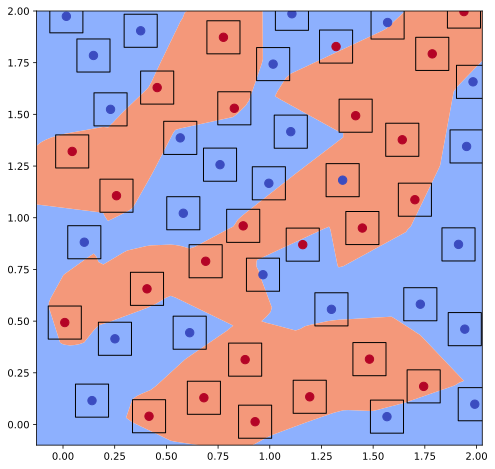

In [23]:
XX, YY = np.meshgrid(np.linspace(-0.2, 2.1, 100), np.linspace(-0.1, 2.1, 100))
X0 = torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T)
y0 = net(X0)
ZZ = (y0[:,0] - y0[:,1]).view(100,100).data.numpy()

fig, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
ax.scatter(x[:,0], x[:,1], c=y, cmap="coolwarm", s=70)
ax.axis("equal")
ax.axis([-0.1,2,-0.1,2])

for a in x:
    ax.add_patch(patches.Rectangle((a[0]-r/2, a[1]-r/2), r, r, fill=False))

# Part 3: Training a provably robust network

While the previous section showed a way to verify networks, it has two major shortcomings on real world problems. First, it is simply too loose to provide meaningful guarantees on standard networks. It is also expensive: even though it is not combinatorially expensive in runtime, solving a linear program is still not scalable to large networks, and is not very fast for use during training. However, in this section we will show that it is possible to compute a computationally tractable bound to the linear program. While this bound is inherently even more loose, we can counteract this with training by learning networks which minimize the bound, and get certified neural networks. 

In [24]:
torch.manual_seed(4)

net = nn.Sequential(
    nn.Linear(2,100),
    nn.ReLU(),
    nn.Linear(100,2)
)

opt = optim.Adam(net.parameters(), lr=1e-3)
X_pt, y_pt = torch.from_numpy(x).float(), torch.from_numpy(y)

W1, b1 = net[0].weight, net[0].bias
W2, b2 = net[2].weight, net[2].bias

In [25]:
def bounds_pt(X, net): 
    X2 = F.linear(X, W1, bias=b1)
    l,u = X2 - epsilon*W1.abs().sum(1), X2 + epsilon*W1.abs().sum(1)
    return torch.clamp(l,max=0), torch.clamp(u,min=0)

In [26]:
class DualNet(nn.Module): 
    def forward(self, c, l, u): 
        nu3 = -c
        nu2hat = F.linear(nu3, W2.t())
        nu2 = u/(u-l)*nu2hat
        nu1 = F.linear(nu2, W1.t())
        return (nu1,nu2,nu3)

dualnet = DualNet()

In [27]:
def bdot(X,Y): 
    return torch.matmul(X.unsqueeze(-2),Y.unsqueeze(-1)).squeeze(-1).squeeze(-1)

def J(nu1, nu2, nu3, l): 
    return (- bdot(nu1, X_pt) - epsilon*nu1.abs().sum(-1)- bdot(nu2, b1) 
            + (l*torch.clamp(nu2,min=0)*I.float()).sum(-1) - bdot(nu3,b2))

In [33]:
import torch.nn.functional as F
for i in range(30000):
    
    # Compute upper and lower bounds
    l,u = bounds_pt(X_pt, net)
    I = (u > 0)*(l < 0)
    
    # Pass through dual network
    c = torch.eye(2)[y_pt]*2-1
    nu1,nu2,nu3 = dualnet(c,l,u)
    
    # Compute objective and loss
    dual_obj = J(nu1,nu2,nu3,l)
    loss = nn.CrossEntropyLoss()(-dual_obj.unsqueeze(-1)*(torch.eye(2)[~y]), y_pt)
    
    # Compute error and robust error
    out = net(torch.from_numpy(x).float())
    err = (out.max(1)[1].data != y_pt).float().mean()
    robust_err = (dual_obj < 0).float().mean()
    
    if i % 500 == 0:
        print(f"loss: {(loss).item():.2f}, err: {err.item():.2f}, robust err: {robust_err.item():.2f}")
    opt.zero_grad()
    (loss).backward()
    opt.step()

loss: 0.58, err: 0.14, robust err: 0.32
loss: 0.58, err: 0.16, robust err: 0.32
loss: 0.58, err: 0.16, robust err: 0.32
loss: 0.58, err: 0.14, robust err: 0.32
loss: 0.58, err: 0.14, robust err: 0.32
loss: 0.58, err: 0.14, robust err: 0.32
loss: 0.58, err: 0.14, robust err: 0.32
loss: 0.58, err: 0.16, robust err: 0.32
loss: 0.58, err: 0.14, robust err: 0.32
loss: 0.58, err: 0.16, robust err: 0.32
loss: 0.58, err: 0.14, robust err: 0.32
loss: 0.58, err: 0.14, robust err: 0.32
loss: 0.57, err: 0.14, robust err: 0.32
loss: 0.57, err: 0.16, robust err: 0.32
loss: 0.57, err: 0.14, robust err: 0.32
loss: 0.57, err: 0.14, robust err: 0.32
loss: 0.57, err: 0.14, robust err: 0.32
loss: 0.57, err: 0.16, robust err: 0.32
loss: 0.57, err: 0.12, robust err: 0.32
loss: 0.57, err: 0.14, robust err: 0.34
loss: 0.57, err: 0.16, robust err: 0.32
loss: 0.57, err: 0.12, robust err: 0.32
loss: 0.57, err: 0.14, robust err: 0.32
loss: 0.57, err: 0.10, robust err: 0.34
loss: 0.57, err: 0.12, robust err: 0.34


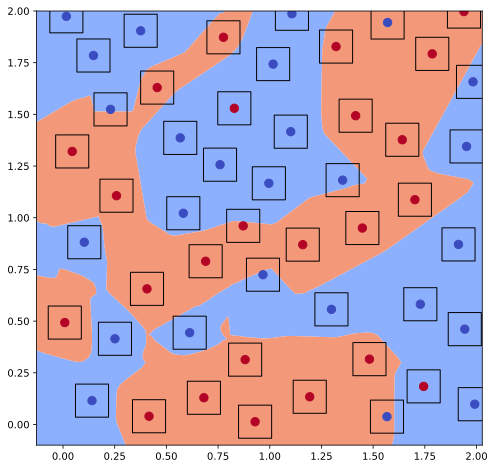

In [34]:
y0 = net(X0)
ZZ = (y0[:,0] - y0[:,1]).view(100,100).data.numpy()

fig, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
ax.scatter(x[:,0], x[:,1], c=y, cmap="coolwarm", s=70)
ax.axis("equal")
ax.axis([-0.1,2,-0.1,2])

for a in x:
    ax.add_patch(patches.Rectangle((a[0]-r/2, a[1]-r/2), r, r, fill=False))